In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

In [2]:
select_group_rows = lambda df, CL, drug: df[(df['CL'] == CL) & (df['DRUG_ID_lib'] == drug)]
select_rows = lambda df, CL, drug: df[(df['CL'] == CL) & (df['drug'] == drug)]
def plot_curve_CD_pair(df, CL, drug, norm=True):
    selected_final_df = select_group_rows(df, CL, drug)
    unique_maxc = selected_final_df['maxc'].unique()
    single_color = len(unique_maxc) == 1
    if single_color:
        print(f'unique maxc values: {unique_maxc[0]}')
        print(f'number of experiments: {len(selected_final_df)}')
    else:
        print(f'number of unique maxc values: {len(unique_maxc)}')
        for maxc in unique_maxc:
            print(f'maxc value: {maxc} with {len(selected_final_df[selected_final_df["maxc"] == maxc])} experiments')
    if norm:
        x_cols = [f'x_{i}' for i in range(7)]
        x_label = 'normalized concentration'
    else:
        x_cols = [f'conc_{i}' for i in range(7)]
        x_label = 'unnormalized concentration'
    y_final_cols = [f'y_{i}' for i in range(7)]
    if single_color:
        for x_col, y_final_cols in zip(x_cols, y_final_cols):
            # If only one unique maxc value, use a single color (e.g., 'blue')
            scatter = plt.scatter(selected_final_df[x_col], selected_final_df[y_final_cols], 
                                color = 'blue', alpha=0.5)
    else:
        for x_col, y_final_cols in zip(x_cols, y_final_cols):
            scatter = plt.scatter(selected_final_df[x_col], selected_final_df[y_final_cols], 
                                c=selected_final_df['maxc'], cmap='viridis', alpha=0.5)
        plt.colorbar(scatter, label='maxc')

    plt.xlabel(x_label)
    plt.ylabel('Dose response')
    plt.title(f'Dose response screening for drug {drug} on cell line {CL}') 
    plt.show()


In [3]:
df = pd.read_csv('./GDSC2_curve_data/Dec16_nn_fitted.csv')
df_raw = pd.read_csv('./GDSC2_curve_data/GDSC2_7_conc_Dec16.csv')

In [4]:
cell_meta = pd.read_csv('./GDSC2_dataset/meta_data/cell_meta.csv')
drug_meta = pd.read_csv('./GDSC2_dataset/meta_data/drug_meta.csv')
df_raw['CL_drug_conc']=  df_raw['CL'].astype(str) + '_' + df_raw['drug']
def GDSC_x_50_from_lnIC50(lnIC50, maxC):
    # Calculate x from lnIC50 using the provided equation
    x = (lnIC50 - np.log(maxC)) / np.log(np.sqrt(10)) + 7
    return x/7
df_raw['IC50_x'] = df_raw.apply(lambda row: GDSC_x_50_from_lnIC50(row['LN_IC50'], row['maxc']), axis=1)
df_raw = df_raw[df_raw.dilution_pattern == 'half-log']
x_cols = [f'x_{i}' for i in range(7)]
y_cols = [f'y_{i}' for i in range(7)]
for i, col in enumerate(x_cols):
    df_raw[col] = (i + 1) / 7

In [5]:
x_values = df_raw[x_cols].values[0]
x_train = torch.tensor(df_raw[x_cols].values[0], dtype=torch.float32).unsqueeze(1)
y_df = torch.tensor(df[y_cols].values, dtype=torch.float32)
x_dense = np.linspace(-0.1, 1.1, 100000)
x_dense_tensor = torch.tensor(x_dense, dtype=torch.float32).unsqueeze(1)
x_train_gpu = x_train.cuda()
y_df_gpu = y_df.cuda()
x_dense_tensor_gpu = x_dense_tensor.cuda()
df_torch = df[['CL_drug_conc', 'CL', 'drug', 'conc'] + y_cols]
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 1000)
        self.fc2 = nn.Linear(1000, 1000)
        self.fc3 = nn.Linear(1000, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
    
def sigmoid_2para(x, p, s):
    return 1.0 / (1 + np.exp((x - p) / -s))

def sigmoid_4para(c, L, k, c_0, d):
    return 1.0 / (L + np.exp(-k * (c - c_0))) + d
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
def calculate_ic50_4_sig(L, k, c_0, d):
    """
    Calculate the IC50 value for a 4-parameter sigmoid model.

    Parameters:
    L, k, c_0, d: Parameters of the sigmoid model

    Returns:
    IC50 value, or 1.5 if the result is NaN
    """
    try:
        ic50 = c_0 - (1 / k) * np.log((2 / (1 - 2 * d)) - L) 
        if np.isnan(ic50):
            return 1.5
        else:
            return ic50
    except:
        return 1.5
    
def calculate_ic50_2_sig(p, s):
    return p


In [6]:
s = 0.05

def count_monotonic_periods(row, s):
    count = 0
    increasing = None  # Track if currently in an increasing period

    for i in range(len(y_cols) - 1):
        if row[y_cols[i + 1]] + s > row[y_cols[i]]:
            # Check for switch from decreasing to increasing
            if increasing == False:
                count += 1
            increasing = True
        else:
            # Check for switch from increasing to decreasing
            if increasing == True:
                count += 1
            increasing = False

    # Add one to count to account for the first monotonic period
    return count + 1 if increasing is not None else 0

# Apply the function to each row
df['monotonic_periods'] = df.apply(count_monotonic_periods, axis=1, args=(s,))


In [7]:
df['count_same_CL_drug_conc'] = df.groupby('CL_drug_conc')['CL_drug_conc'].transform('count')

In [8]:
def get_min_rmse_row(group):
    # Find the row index with the minimum rmse_4_para
    idx_min_rmse_4_para = group['rmse_4_para'].idxmin()
    # Find the row index with the minimum rmse_2_para
    idx_min_rmse_2_para = group['rmse_2_para'].idxmin()
    
    # Compare the minimum RMSE values and return the index of the overall minimum
    if group.loc[idx_min_rmse_4_para, 'rmse_4_para'] < group.loc[idx_min_rmse_2_para, 'rmse_2_para']:
        return idx_min_rmse_4_para
    else:
        return idx_min_rmse_2_para

# Group the DataFrame by 'CL_drug_conc' and apply the function
min_rmse_indices = df.groupby('CL_drug_conc').apply(get_min_rmse_row)


# Use the unique indices to filter the rows in 'fitted_sub_df'
deduplicated_sub_df = df.loc[min_rmse_indices]
# deduplicated_sub_df.reset_index(drop=True, inplace=True)
monoton_1_df = df[df.monotonic_periods == 1]
monoton_2_df = df[df.monotonic_periods == 2]
monoton_3_df = df[df.monotonic_periods == 3]
monoton_4_df = df[df.monotonic_periods == 4]
monoton_5_df = df[df.monotonic_periods == 5]
monoton_6_df = df[df.monotonic_periods == 6]

unique maxc values: 0.1
number of experiments: 247


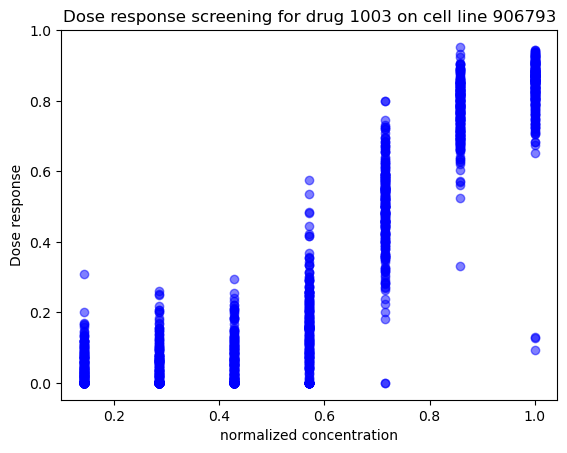

In [10]:
plot_curve_CD_pair(df = df_raw, CL =906793, drug = 1003)

In [11]:
def plot_group_curves(df, row_index, show_nn = False, show_2_para = True, show_4_para = True, show_nn_group = True):
    fig, ax = plt.subplots(dpi=200)
    sub_row = df.iloc[row_index]
    y_values = sub_row[y_cols].values
    GDSC_IC50 = sub_row['IC50_x']
    sigmoid_4_IC50 = sub_row['IC50_4_para']
    sigmoid_2_IC50 = sub_row['IC50_2_para']
    if sigmoid_2_IC50 > 1.5:
        sigmoid_2_IC50 = 1.5
    if sigmoid_4_IC50 > 1.5:
        sigmoid_4_IC50 = 1.5
    if sigmoid_2_IC50 < 0:
        sigmoid_2_IC50 = 0
    if sigmoid_4_IC50 < 0:
        sigmoid_4_IC50 = 0
    # IC_50_NN = sub_row['IC_50_NN']
    rmse_nn = sub_row['rmse_nn_group']
    IC_50_NN_group = sub_row['IC_50_NN_group']
    if show_nn:
        model_nn_para = torch.load(f'./fitting_curve/weight/NN_curve_{row_index}.pth')
        model = Net()
        model.load_state_dict(model_nn_para)
        y_dense_tensor = model(x_dense_tensor)
        pred_nn = model(x_train)
    if show_nn:
        model_nn_para = torch.load(f'./fitting_curve/weight/NN_curve_{row_index}.pth')
        model = Net()
        model.load_state_dict(model_nn_para)
        y_dense_tensor_ = model(x_dense_tensor)
        pred_nn_ = model(x_train)
    if show_nn_group:
        pair = sub_row.CL_drug_conc
        model_nn_para = torch.load(f'./fitting_curve/weight_group/NN_curve_{pair}.pth')
        model = Net()
        model.load_state_dict(model_nn_para)
        y_dense_tensor = model(x_dense_tensor)
        pred_nn_group = model(x_train)
        rmse_nn_group = nn.MSELoss()(pred_nn_group.squeeze(dim = 1), torch.tensor(y_values.astype(np.float32))).item()
    sigmoid_4_model_cols = ['4_para_0', '4_para_1', '4_para_2', '4_para_3']
    sigmoid_2_model_cols = ['2_para_0', '2_para_1']
    sigmoid_4_dict = {'rmse': sub_row['rmse_4_para'], 'model': sub_row[sigmoid_4_model_cols]}
    sigmoid_2_dict = {'rmse': sub_row['rmse_2_para'], 'model': sub_row[sigmoid_2_model_cols]}
    CL,drug_name,maxc = sub_row.CL_drug_conc.split('_')
    cell_name = cell_meta[cell_meta.COSMIC_ID == int(CL)].CELL_LINE_NAME.unique()[0]
    if int(drug_name) in drug_meta.DRUG_ID.unique():
        drug_identifier = drug_meta[drug_meta.DRUG_ID == int(drug_name)].DRUG_NAME.unique()[0]
    else:
        drug_identifier = drug_name
    a, b = sigmoid_2_dict['model']
    # x_high = max(4*b + a, 1.1)
    # x_high = min(x_high, 1.5)
    # x_low = min(-4*b + a, 0)
    # x_low = max(x_low, -1.)
    y_low = min(y_values) - 0.2
    y_low = max(y_low, -0.1)
    y_high = max(y_values) + 0.2
    y_high = min(y_high, 1.1)
    x_high = 1.1
    x_low = -0.1
    ## use np linspace to generate 1000 points between x_low and x_high      
    x_dense = np.linspace(x_low, x_high, 1000)
    rmse_sigmoid_2_predictions = sigmoid_2_dict['rmse']
    predicted_sig_2para = sigmoid_2para(x_dense, a, b)
    pred_sig2_y = sigmoid_2para(x_values, a, b)
    pred_sig4_y = sigmoid_4para(x_values, *sigmoid_4_dict['model'])
    L_fit, k_fit, x0_fit, d_fit = sigmoid_4_dict['model']
    rmse_sigmoid_4_predictions = sigmoid_4_dict['rmse']
    predicted_sig_4para = sigmoid_4para(x_dense, L_fit, k_fit, x0_fit, d_fit)
    ## Curves
    if show_2_para:
        plt.plot(x_dense, predicted_sig_2para, label=f'Fitted Sigmoid 2-Parameter\nRMSE: {rmse_sigmoid_2_predictions:.3f}', color = '#3C5488FF')
    if show_4_para:
        plt.plot(x_dense, predicted_sig_4para, label=f'Fitted Sigmoid 4-Parameter\nRMSE: {rmse_sigmoid_4_predictions:.3f}', color='#F39B7FFF')
    if show_nn:
        plt.plot(x_dense_tensor, y_dense_tensor_.detach().numpy(), label=f'Fitted Neural network\nRMSE: {rmse_nn:.3f}', color = '#00A087FF')
    if show_nn_group:
        plt.plot(x_dense_tensor, y_dense_tensor.detach().numpy(), label=f'Fitted Neural network group\nRMSE: {rmse_nn_group:.3f}', color = '#00A087FF')
    ## Scatter
    plt.scatter(x_values, y_values, color='black', marker='o', facecolors='none', edgecolors='black', label = 'Observation')
    if show_2_para:
        plt.scatter(x_values, pred_sig2_y, marker='^', color='#3C5488FF', label='2_para prediction')
    if show_4_para:
        plt.scatter(x_values, pred_sig4_y, marker='^', color='#F39B7FFF', label='4_para prediction') 
    if show_nn:
        plt.scatter(x_values, pred_nn_.detach().numpy(), marker='^', color='#00A087FF', label='NN prediction')  
    if show_nn_group:
        plt.scatter(x_values, pred_nn_group.detach().numpy(), marker='^', color='#00A087FF', label='NN prediction with group')
    ## GDSC IC50    
    plt.scatter(GDSC_IC50, [0.5], color='red', marker='s', s=40, alpha=0.6)  # 's' for square shape
    plt.axvline(GDSC_IC50, color='red', linestyle='dashed', linewidth= 1, label=f'GDSC IC50: {GDSC_IC50:.3f}')
    ## 2 para
    if show_2_para:
        plt.scatter(sigmoid_2_IC50, [0.5], color='#3C5488FF', marker='s', s=40, alpha=0.6)  # 's' for square shape
        plt.axvline(sigmoid_2_IC50, color='#3C5488FF', linestyle='dashed', linewidth=1, label=f'2_para IC50: {sigmoid_2_IC50:.3f}')
    ## 4 para
    if show_4_para:
        plt.scatter(sigmoid_4_IC50, [0.5], color='#F39B7FFF', marker='s', s=40, alpha=0.6)  # 's' for square shape
        plt.axvline(sigmoid_4_IC50, color='#F39B7FFF', linestyle='dashed', linewidth = 1, label=f'4_para IC50: {sigmoid_4_IC50:.3f}')
    ## NN for IC50   
    if show_nn:
        plt.scatter(IC50_NN, [0.5], color='teal', marker='s', s=40, alpha=0.6)  # 's' for square shape
        plt.axvline(IC50_NN, color='teal', linestyle='dashed', linewidth=1, label=f'NN IC50: {IC50_NN:.3f}')    
    if show_nn_group:
        plt.scatter(IC_50_NN_group, [0.5], color='#B23AEE', marker='s', s=40, alpha=0.6)
        plt.axvline(IC_50_NN_group, color='#B23AEE', linestyle='dashed', linewidth=1, label=f'NN group IC50: {IC_50_NN_group:.3f}')
    plt.axhline(0.5, color='black', linestyle='-.', linewidth= 1, label = 'Response Level 50%')
    plt.xlabel('Normalized concentration', fontsize=12)
    plt.ylabel('Normalized response', fontsize=12)
    plt.ylim(y_low, 1.1)
    # drug_name = drug.split('_')[0]
    # maxc = drug.split('_')[1]
    plt.title(f'Dose-response curves for drug {drug_name} on cell line {CL} with max concentration {maxc} µM')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    annotation_x = x_low + (x_high - x_low) * 0.1 # Adjust horizontal position
    annotation_y = 0.8
    plt.annotate(f"Cell-line: {cell_name}\n\nDrug: {drug_identifier}\n\nMax dose = {maxc} uM",
                    (annotation_x, annotation_y), ha='left', va='center', fontsize= 11, xycoords='axes fraction')

    plt.grid(False)
    return fig, ax

In [12]:
df[(df.count_same_CL_drug_conc >100) & (df.monotonic_periods == 3)].CL_drug_conc.unique()

array(['753608_1003_0.1', '753608_1007_0.0125', '753608_1179_10',
       '905939_1060_2.5', '905962_1060_2.5', '906793_1003_0.1',
       '906793_1032_10', '906793_1060_2.5', '906793_1372_1',
       '906830_1003_0.1', '906830_1060_2.5', '906830_1372_1',
       '908134_1003_0.1', '908134_1032_10', '909776_1060_2.5',
       '909776_1372_1'], dtype=object)

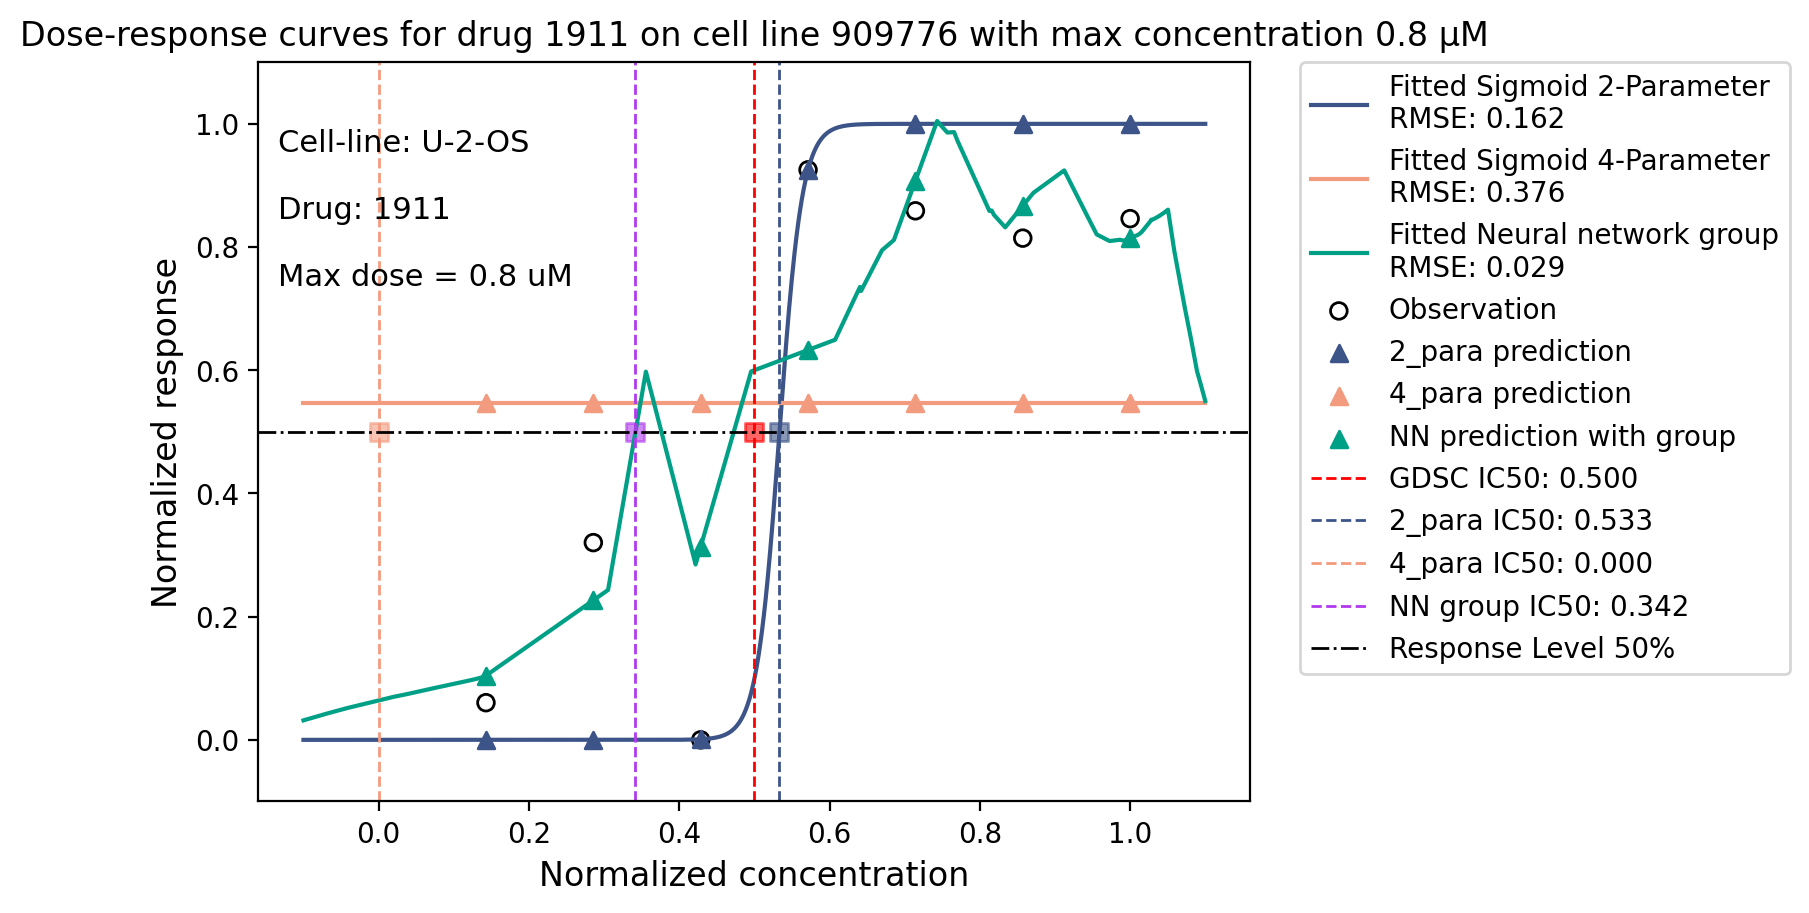

In [14]:
fig, ax = plot_group_curves(df = df, row_index=34985, show_nn=False)
fig.savefig('./fitting_curve/Figures/curve_fitting/inverse_U_curve.pdf', dpi=300, bbox_inches='tight', format='pdf')

In [15]:
def plot_all_observation_curves(df, CL, drug, show_2_para = True, show_4_para = True, show_nn_group = True):
    sub_row = select_rows(df = df, CL = CL, drug = drug)
    best_idx_2_para = sub_row['rmse_2_para'].idxmin()
    best_idx_4_para = sub_row['rmse_4_para'].idxmin()
    y_values = sub_row[y_cols].values
    GDSC_IC50 = sub_row['IC50_x'].unique()[0]
    sigmoid_4_IC50 = sub_row.loc[best_idx_4_para,'IC50_4_para']
    sigmoid_2_IC50 = sub_row.loc[best_idx_2_para,'IC50_2_para']
    sigmoid_2_rmse = sub_row.loc[best_idx_2_para,'rmse_2_para']
    sigmoid_4_rmse = sub_row.loc[best_idx_4_para,'rmse_4_para']
    if sigmoid_2_IC50 > 1.5:
        sigmoid_2_IC50 = 1.5
    if sigmoid_4_IC50 > 1.5:
        sigmoid_4_IC50 = 1.5
    if sigmoid_2_IC50 < 0:
        sigmoid_2_IC50 = 0
    if sigmoid_4_IC50 < 0:
        sigmoid_4_IC50 = 0
    # IC_50_NN = sub_row['IC_50_NN']
    rmse_nn_group = sub_row['rmse_nn_group'].values[0]
    IC_50_NN_group = sub_row['IC_50_NN_group'].values[0]

    pair = sub_row.CL_drug_conc.unique()[0]
    model_nn_para = torch.load(f'./fitting_curve/weight_group/NN_curve_{pair}.pth')
    if show_nn_group:
        pair = sub_row.CL_drug_conc.unique()[0]
        model_nn_para = torch.load(f'./fitting_curve/weight_group/NN_curve_{pair}.pth')
        model = Net()
        model.load_state_dict(model_nn_para)
        y_dense_tensor = model(x_dense_tensor)
        pred_nn_group = model(x_train)
        # rmse_nn_group = nn.MSELoss()(pred_nn_group.squeeze(dim = 1), torch.tensor(y_values.astype(np.float32))).item()
    sigmoid_4_model_cols = ['4_para_0', '4_para_1', '4_para_2', '4_para_3']
    sigmoid_2_model_cols = ['2_para_0', '2_para_1']
    sigmoid_4_dict = {'rmse': sigmoid_4_rmse, 'model': sub_row.loc[best_idx_4_para, sigmoid_4_model_cols]}
    sigmoid_2_dict = {'rmse': sigmoid_2_rmse, 'model': sub_row.loc[best_idx_2_para, sigmoid_2_model_cols]}
    CL,drug_name,maxc = sub_row.CL_drug_conc.unique()[0].split('_')
    cell_name = cell_meta[cell_meta.COSMIC_ID == int(CL)].CELL_LINE_NAME.unique()[0]
    if int(drug_name) in drug_meta.DRUG_ID.unique():
        drug_identifier = drug_meta[drug_meta.DRUG_ID == int(drug_name)].DRUG_NAME.unique()[0]
    else:
        drug_identifier = drug_name
    a, b = sigmoid_2_dict['model']
    # x_high = max(4*b + a, 1.1)
    # x_high = min(x_high, 1.5)
    # x_low = min(-4*b + a, 0)
    # x_low = max(x_low, -1.)
    y_low = y_values.min() - 0.2
    y_low = max(y_low, -0.1)
    y_high = y_values.max() + 0.2
    y_high = min(y_high, 1.1)
    x_high = 1.1
    x_low = -0.1
    ## use np linspace to generate 1000 points between x_low and x_high      
    x_dense = np.linspace(x_low, x_high, 1000)
    rmse_sigmoid_2_predictions = sigmoid_2_dict['rmse']
    predicted_sig_2para = sigmoid_2para(x_dense, a, b)
    pred_sig2_y = sigmoid_2para(x_values, a, b)
    pred_sig4_y = sigmoid_4para(x_values, *sigmoid_4_dict['model'])
    L_fit, k_fit, x0_fit, d_fit = sigmoid_4_dict['model']
    rmse_sigmoid_4_predictions = sigmoid_4_dict['rmse']
    predicted_sig_4para = sigmoid_4para(x_dense, L_fit, k_fit, x0_fit, d_fit)
    fig, ax = plt.subplots(dpi=200)
    ## Curves
    if show_2_para:
        plt.plot(x_dense, predicted_sig_2para, label=f'Fitted Sigmoid 2-Parameter\nRMSE: {rmse_sigmoid_2_predictions:.3f}', color = '#3C5488FF')
    if show_4_para:
        plt.plot(x_dense, predicted_sig_4para, label=f'Fitted Sigmoid 4-Parameter\nRMSE: {rmse_sigmoid_4_predictions:.3f}', color='#F39B7FFF')
    if show_nn_group:
        plt.plot(x_dense_tensor, y_dense_tensor.detach().numpy(), label=f'Fitted Neural network group\nRMSE: {rmse_nn_group:.3f}', color = '#00A087FF')
    ## Scatter
    for i, (x_col, y_final_cols) in enumerate(zip(x_cols, y_cols)):
        # If only one unique maxc value, use a single color (e.g., 'blue')
        x_value_tmp = x_values[i]
        ## Repeat x_value_tmp for len(sub_row) times
        x_value_tmp = np.repeat(x_value_tmp, len(sub_row))
        if i == 0:
            scatter = plt.scatter(x_value_tmp, sub_row[y_final_cols], 
                                color='black', marker='o', facecolors='none', edgecolors='black', label = 'Observation', alpha=0.5)
        else:
            scatter = plt.scatter(x_value_tmp, sub_row[y_final_cols], 
                                color='black', marker='o', facecolors='none', edgecolors='black', alpha=0.5)
    # plt.scatter(x_values, y_values, color='black', marker='o', facecolors='none', edgecolors='black', label = 'Observation')
    if show_2_para:
        plt.scatter(x_values, pred_sig2_y, marker='^', color='#3C5488FF', label='2_para prediction')
    if show_4_para:
        plt.scatter(x_values, pred_sig4_y, marker='^', color='#F39B7FFF', label='4_para prediction') 
    if show_nn_group:
        plt.scatter(x_values, pred_nn_group.detach().numpy(), marker='^', color='#00A087FF', label='NN prediction with group')
    ## GDSC IC50    
    plt.scatter(GDSC_IC50, [0.5], color='red', marker='s', s=40, alpha=0.6)  # 's' for square shape
    plt.axvline(GDSC_IC50, color='red', linestyle='dashed', linewidth= 1, label=f'GDSC IC50: {GDSC_IC50:.3f}')
    ## 2 para
    if show_2_para:
        plt.scatter(sigmoid_2_IC50, [0.5], color='#3C5488FF', marker='s', s=40, alpha=0.6)  # 's' for square shape
        plt.axvline(sigmoid_2_IC50, color='#3C5488FF', linestyle='dashed', linewidth=1, label=f'2_para IC50: {sigmoid_2_IC50:.3f}')
    ## 4 para
    if show_4_para:
        plt.scatter(sigmoid_4_IC50, [0.5], color='#F39B7FFF', marker='s', s=40, alpha=0.6)  # 's' for square shape
        plt.axvline(sigmoid_4_IC50, color='#F39B7FFF', linestyle='dashed', linewidth = 1, label=f'4_para IC50: {sigmoid_4_IC50:.3f}')
    ## NN for IC50      
    if show_nn_group:
        plt.scatter(IC_50_NN_group, [0.5], color='#3D9140', marker='s', s=40, alpha=0.6)
        plt.axvline(IC_50_NN_group, color='#3D9140', linestyle='dashed', linewidth=1, label=f'NN group IC50: {IC_50_NN_group:.3f}')
    plt.axhline(0.5, color='black', linestyle='-.', linewidth= 1, label = 'Response Level 50%')
    plt.xlabel('Normalized concentration', fontsize=12)
    plt.ylabel('Normalized response', fontsize=12)
    plt.ylim(y_low, 1.1)
    # drug_name = drug.split('_')[0]
    # maxc = drug.split('_')[1]
    plt.title(f'Dose-response curves for drug {drug_name} on cell line {CL} with max concentration {maxc} µM')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    annotation_x = x_low + (x_high - x_low) * 0.1 # Adjust horizontal position
    annotation_y = 0.8
    plt.annotate(f"Cell-line: {cell_name}\n\nDrug: {drug_identifier}\n\nMax dose = {maxc} uM",
                    (annotation_x, annotation_y), ha='left', va='center', fontsize= 11, xycoords='axes fraction')

    plt.grid(False)